In [27]:
# importing necessary Packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import plotly.express as pe
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import  mean,std
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency,levene,shapiro
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,Normalizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier,XGBRFClassifier

In [28]:
# reading the data 
df=pd.read_csv('bank.csv',sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# number of customers
print('number of customers: {}'.format(df.shape[0]))

number of customers: 45211


#  Data preparation and answering the business questions
 
From our data dictionary, some categorical variables have missing values, i.e. job, education, contact, and outcome of the old marketing campaign. 

To answer the first three questions, having the current categorical variables with missing values is not an issue. 

The missing values in the outcome of the old marketing campaign are our only issue. 

To address this issue, we ignore the rows that contain "unknown", and "other" in the outcome column.

The reason for this is that we need to know the final result of the old campaign, and "unknown", and "other" do not give us any hint regarding the result of the old campaign.

### Question 1: did the new campaign perform significantly different (better or worse) than the old one?

As we stated before, the dataset contains information about the result of the new marketing campaign for the bank.

Moreover, we have the result of the previous marketing campaign via column poutcome. 

Here, our goal is to evaluate the performance of the new campaign compared to the previous one. 

To reach this goal, we will perform statistical hypothesis testing. 

Based on the definition of column pdays, we have some new customers, who were not previously contacted during the previous campaign.

The new customers are also detectable via column previous. 

pdays: the number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means the client was not previously contacted.

Therefore, we build the treatment group based on the new customers.  

Let's see the number of new and old users.

In [4]:
dic_custoemrs = {'number of new customers': [df[(df['previous'] == 0)].shape[0]], 
     'number of old customers': [df[(df['previous'] != 0)].shape[0]]}
d_customers = pd.DataFrame(data=dic_custoemrs)
d_customers.head()

,number of new customers,number of old customers
0,36954,8257


Since in A/B testing, the control group should not be contacted during the new campaign, we build the treatment group by the new customers (36954 individuals), and the control group is built by the old customers (8257 individuals).

Next, the control group is built as follows: 

We add two new columns:

Column **group** whose all rows equal control, i.e. determines the instance belongs to the control group. 

Column **result**, which determines whether the customers said yes to both campaigns or not (1 means yes, 0 means no).

In [5]:
class Generator:
    """This class generates the treatment and control groups
         args: dataframe, the main dataframe
         returns: dataframe, control and treatment gropus"""
    
    def __init__(self, table):
        self.table= table
        
    def control_generator(self):
        self.table.loc[:,'group'] = 'control'
        self.table.loc[self.table['poutcome']!='success', 'result'] = 0
        self.table.loc[self.table['poutcome']=='success', 'result'] = 1
        self.df_control = self.table[(self.table['previous'] != 0)&((self.table['poutcome']=='success') |(self.table['poutcome']=='failure'))]
        self.table.drop(columns=['result','group'],axis=1, inplace=True)
        return self.df_control, self.table
    
    def treatment_generator(self):
        self.table.loc[:,'group'] = 'treatment'
        self.table.loc[df['y']=='no', 'result'] = 0
        self.table.loc[df['y']=='yes', 'result'] = 1
        self.df_treat=df[(df['previous'] == 0)& (df['campaign']>=1)]
        self.table.drop(columns=['result','group'],axis=1, inplace=True)
        return self.df_treat,self.table

In [6]:
# generating the control group 
item=Generator(df)
df_control,df=item.control_generator()
df_control.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,group,result
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no,control,0.0
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes,control,0.0
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes,control,0.0
24080,56,technician,married,secondary,no,589,yes,no,unknown,23,oct,518,1,147,2,success,yes,control,1.0
24127,51,admin.,single,secondary,no,3132,no,no,telephone,5,nov,449,1,176,1,failure,no,control,0.0


Next, we build the treatment group via the new customers.

In [7]:
# generating the treatment group 
df_treat,df=item.treatment_generator()
df_treat.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,group,result
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,treatment,0.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,treatment,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,treatment,0.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,treatment,0.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,treatment,0.0


### Evaluation metric:

Our metric to compare the results of the campaigns is conversion rate, which determines that
what portion of the customers said yes to the campaign.

The conversion rate of the old campaign can be represented as follows:

In [8]:
conversion_rate=df_control[df_control.poutcome=='success'].shape[0]/(df_control[df_control.poutcome=='success'].shape[0]
                                                               +df_control[df_control.poutcome=='failure'].shape[0])
print("conversion rate of the old campaign: {0:.3f}".format(conversion_rate))

conversion rate of the old campaign: 0.236


Next, we obtain the sample size to perform the A/B testing via power analysis.

We assume that our expectation is that the new campaign increases the conversion rate from 23.6% to 26.6%.

Library Statsmodels is used to determine the sample size.

**Please note that our significance level for all statistical tests is 0.05.**

In [9]:
effect_size = sms.proportion_effectsize(0.236, 0.266)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                           
print("required number of samples:{}".format(ceil(required_n)))

required number of samples:3277


We need at least 3277 samples. Thus, we choose 3500 samples randomly.

In [11]:
control_sample = df_control.sample(n=3500, random_state=42)
treatment_sample =df_treat.sample(n=3500, random_state=42)

First, we concatenate both control and treatment samples to perform our A/B testing. 

In [12]:
df_test = pd.concat([control_sample, treatment_sample], axis=0)
df_test.reset_index(drop=True, inplace=True)
df_test.drop(columns=['poutcome','y'],axis=1, inplace=True)
df_test.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,group,result
6995,30,blue-collar,married,primary,no,70,yes,yes,unknown,8,may,461,3,-1,0,treatment,0.0
6996,42,services,married,secondary,no,1263,yes,no,unknown,6,may,114,2,-1,0,treatment,0.0
6997,38,management,married,tertiary,no,516,yes,no,telephone,16,apr,198,3,-1,0,treatment,0.0
6998,39,entrepreneur,married,tertiary,no,0,yes,no,cellular,14,jul,111,2,-1,0,treatment,0.0
6999,36,self-employed,single,tertiary,no,-103,yes,yes,telephone,17,oct,3253,1,-1,0,treatment,1.0


In [13]:
conversion_rates = df_test.groupby('group')['result']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.245,0.430,0.007
treatment,0.089,0.285,0.005


From the above table, the conversion rate of the old campaign is noticeably higher than the new one.

Therefore, the new campaign was not successful.

To answer the question **is this difference statistically significant?**, we will leverage the z-test.

But, before that, we need to define a class that contains all required statistical tests.

In [14]:
class tests:
    """This class applies required statistical tests to implement statistical hypothesis testing
         args: x: a specific column of the control group, y: a specific column of the treatment group
         return: the result of the test"""
    
    def __init__(self, x,y):
        self.x= x
        self.y=y
    
    def levene_test(self):
        p_value=levene(self.x, self.y)[1]
        print("levene p-value: {0:.3f}".format(p_value))
        if p_value < 0.05:
            print('Reject null hypothesis:  the variance between groups is not equal ')
        else:
             print('Fail to reject the null hypothesis: the groups have equal variance')
                
    def z_test(self):
        p_value=ztest(self.x, self.y, value=0) [1]
        print("z test p-value: {0:.3f}".format(p_value))
        if p_value < 0.05:
            print('Reject null hypothesis: the difference between the groups is statistically significant')
        else:
             print('Fail to reject the null hypothesis: the difference between the groups is statistically insignificant')
    
    def mann_Whitney_test(self):
        man_val=stats.mannwhitneyu(self.x, self.y, alternative = 'two-sided')[1]
        print("Mann-Whitney p-value criterion: {0:.3f}".format(man_val))
        if man_val < 0.05:
            print('Reject null hypothesis: the difference between the groups is statistically significant')
        else:
             print('Fail to reject the null hypothesis: the difference between the groups is statistically insignificant')
    
    def chi_Square_test(self):
        p_value=chi2_contingency(self.x)[1]
        print("Chi-Square test p-value: {0:.3f}".format(p_value))
        if p_value < 0.05:
             print('Reject null hypothesis: the difference between the groups is statistically significant')
        else:
             print('Fail to reject the null hypothesis: the difference between the groups is statistically insignificant')
    
    def welch_test(self):
        man_val=stats.ttest_ind(self.x, self.y, equal_var=False)[1]
        print("Mann-Whitney p-value criterion: {0:.3f}".format(man_val))
        if man_val < 0.05:
            print('Reject null hypothesis: the difference between the groups is statistically significant')
        else:
             print('Fail to reject the null hypothesis: the difference between the groups is statistically insignificant')

Now, we apply our A/B testing: 

In [15]:
control_results = df_test[df_test['group'] == 'control']['result']
treatment_results = df_test[df_test['group'] == 'treatment']['result']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print("z statistic: {0:.2f}".format(z_stat))
print("p value: {0:.3f}".format(pval))

z statistic: 17.50
p value: 0.000


In [16]:
item=tests(control_results, treatment_results)
item.mann_Whitney_test()

Mann-Whitney p-value criterion: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


**Answer to question 1: Both tests show that the difference between the results of both campaigns is significant as expected.**

**In fact, the old campaign was more successful than the new one.**

### Is there any bias between the new and old campaigns?

To identify biases, the question to ask is whether there are variables that are not constant across the groups of the population. biases are also variables that can affect the outcome of the experiment.

To identify biases, we leverage statistical tests, i.e, the z-test, Chi-Square test, Levene's test, and the Mann-Whitney U test.

As the first variable, we consider the number of calls during two campaigns because it can affect our result.

One can say that multiple calls may change customers' opinions. To this end, we plot the following figure:

In [17]:
class Plot:
    """This class plots required histograms and box-plots
         args: X: dataframe, control group, 
               Y: dataframe, treatment group,
               col_1: a specific column of control group,
               col_2: a specific column of treatment group,
               v_control:binary, a variable that controls which columns
                             of X and Y should be included in the box-plot
         returns: histogram and box-plot figures"""
    
    def __init__(self, X,Y,col_1,col_2,X_col,Y_col,v_control):
        self.X= X
        self.Y=Y
        self.col_1=col_1
        self.col_2=col_2
        self.X_col=X_col
        self.Y_col=Y_col
        self.v_control=v_control
        
    def plot(self):
        fig, axes = plt.subplots(1, 4, figsize = (18,5))
        self.X.hist(self.col_1, ax = axes[0], color = "steelblue")
        self.Y.hist(self.col_2, ax = axes[1], color = "steelblue")
        if self.v_control==0:
            sns.boxplot(x = self.X.group, y = self.X_col, ax = axes[2])
            sns.boxplot(x = self.Y.group, y = self.Y_col, ax = axes[3])
        else:
            sns.boxplot(x = self.X.y, y = self.X_col, ax = axes[2])
            sns.boxplot(x = self.Y.y, y = self.Y_col, ax = axes[3])
        axes[0].set_title(" the previous campaign", fontsize = 15)
        axes[1].set_title(" the new campaign", fontsize = 15)
        axes[2].set_title(" the previous campaign", fontsize = 15)
        axes[3].set_title(" the new campaign", fontsize = 15)
        plt.tight_layout(pad = 4)

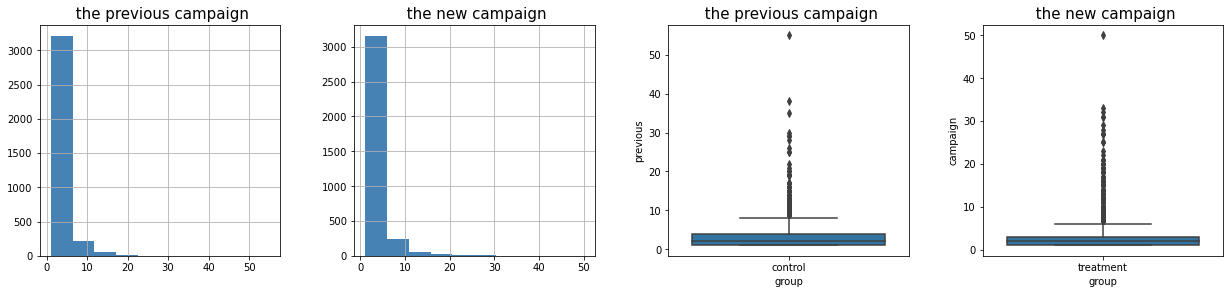

In [18]:
item=Plot(control_sample,treatment_sample,'previous','campaign',control_sample.previous,treatment_sample.campaign,0)
item.plot()

based on the box plot of the calls during the old campaign, there is an anomaly.

First, we should remove it. 

In [19]:
control_sample = control_sample[control_sample.previous < control_sample.previous.max()]

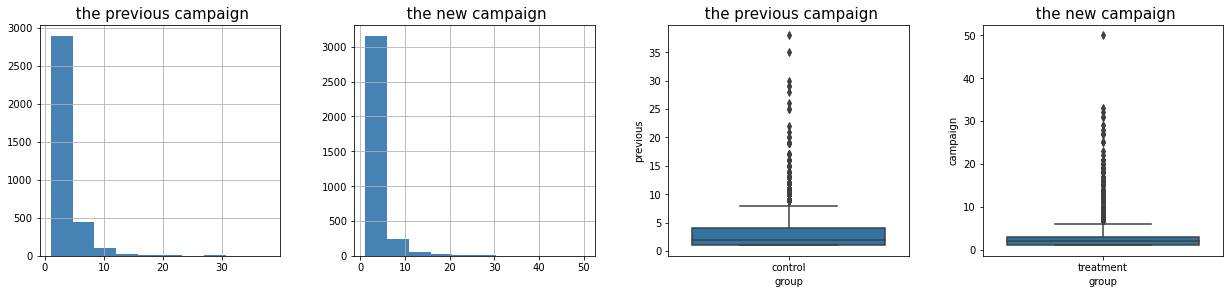

In [20]:
item=Plot(control_sample,treatment_sample,'previous','campaign',control_sample.previous,treatment_sample.campaign,0)
item.plot()

Now, both box plots are ok.

From the histograms of both campaigns, roughly, calls are normally distributed.

Next, we use Levene's test to determine whether variance between groups is equal or not.

If the test can not reject the null hypothesis, we will use the z-test to detect any statistical difference between groups.

In [21]:
item=tests(control_sample['previous'], treatment_sample['campaign'])
item.levene_test()

levene p-value: 0.761
Fail to reject the null hypothesis: the groups have equal variance


In [22]:
item.z_test()

z test p-value: 0.210
Fail to reject the null hypothesis: the difference between the groups is statistically insignificant


The difference in the number of calls between the groups is not statistically significant.

Consequently, the number of calls is not a bias.

Next, we test variable age.

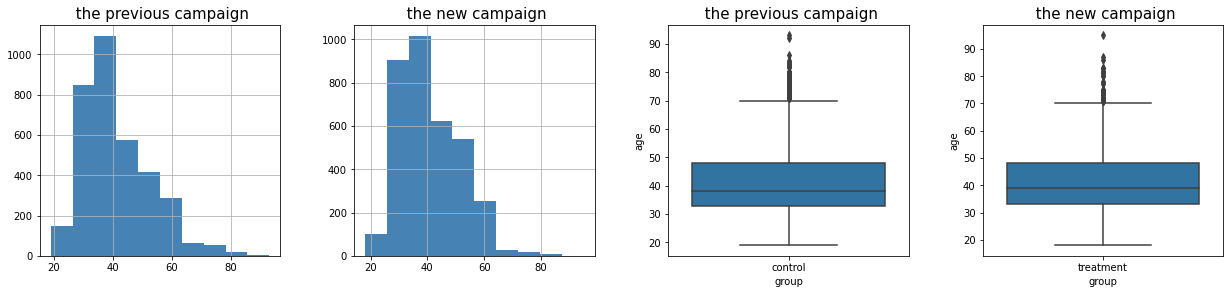

In [23]:
item=Plot(control_sample,treatment_sample,'age','age',control_sample.age,treatment_sample.age,0)
item.plot()

The histograms of both groups show some skewness, but roughly we accept that age is normally distributed. 

However, we also apply the Mann-Whitney U test, which is a non-parametric test, since our assumption about age distribution may not be realistic.

Next, we use Levene's test to determine whether variance between groups is equal or not. 

If the test can not reject the null hypothesis, we will use the z-test to detect any statistical difference between groups.

In [24]:
item=tests(control_sample['age'], treatment_sample['age'])
item.levene_test()

levene p-value: 0.093
Fail to reject the null hypothesis: the groups have equal variance


In [25]:
item.z_test()

z test p-value: 0.244
Fail to reject the null hypothesis: the difference between the groups is statistically insignificant


In [26]:
item.mann_Whitney_test()

Mann-Whitney p-value criterion: 0.919
Fail to reject the null hypothesis: the difference between the groups is statistically insignificant


According to both tests, age is not a bias.

Next, we test variables having housing loan and personal loan.

Since both variables are categorical, we use the Chi-Square test to identify any statistical difference.

Please note that we assume that variables having housing loans and personal loan for both campaigns are the same.

We use the following function to generate the required contingency tables.

In [27]:
def contingency_generator(treatment_sample,control_sample,name):
    d_table=[[treatment_sample[treatment_sample[name]=='no'].shape[0],
             treatment_sample[treatment_sample[name]=='yes'].shape[0]],
            [control_sample[control_sample[name]=='no'].shape[0],
             control_sample[control_sample[name]=='yes'].shape[0]]]
    return d_table

In [28]:
d_personal_loan=contingency_generator(treatment_sample,control_sample,'loan')
d_housing=contingency_generator(treatment_sample,control_sample,'housing')

In [30]:
item=tests(d_personal_loan,None)
item.chi_Square_test()

Chi-Square test p-value: 0.011
Reject null hypothesis: the difference between the groups is statistically significant


In [147]:
item=tests(d_housing,None)
item.chi_Square_test()

Chi-Square test p-value: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


The Chi-Square test shows that the difference between groups in terms of having housing and personal loans is significant. 

Thus, these variables can be a bias.

**Answer to question 2: It seems that there is a bias between two campaigns in terms of having housing and personal loans.**

### Question 3: to increase the conversion rate of future campaigns, which variables are important?

The new campaign was not successful. Now, we try to identify variables that could be important for the success of future marketing campaigns.

To do this, we use the data related to the new marketing campaign.

First, we split the data into two groups, i.e., people who said yes to the campaign and people who said no. 

For the group of people who said no we should do sampling since only 9% of people said yes to the campaign.  

The average yearly balance is the first variable that we consider.  

Here, **the question is whether the amount of the average yearly balance and subscribing to the bank term deposit are related to each other?**

Since the average yearly balance is continuous and our sample size is large we will leverage the z-test or Welch's t-test to answer the question.

In [66]:
df_success = df[df['y']=='yes'] 
df_fail = df[df['y']=='no'] 
df_fail=df_fail.sample(n=df_success.shape[0], random_state=42)

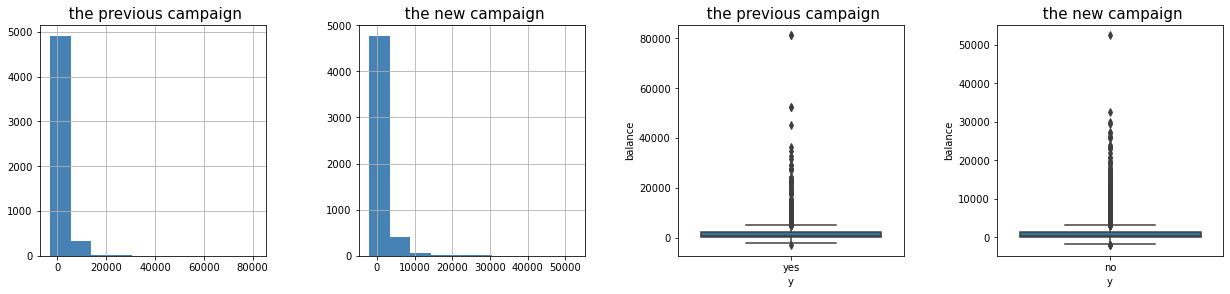

In [32]:
item=Plot(df_success,df_fail,'balance','balance',df_success.balance,df_fail.balance,1)
item.plot()

Based on the box plots of both groups, there are some anomalies. 

First, we remove those anomalies. 

In [33]:
df_success = df_success[df_success.balance < df_success.balance.max()]
df_fail = df_fail[df_fail.balance < df_fail.balance.max()]

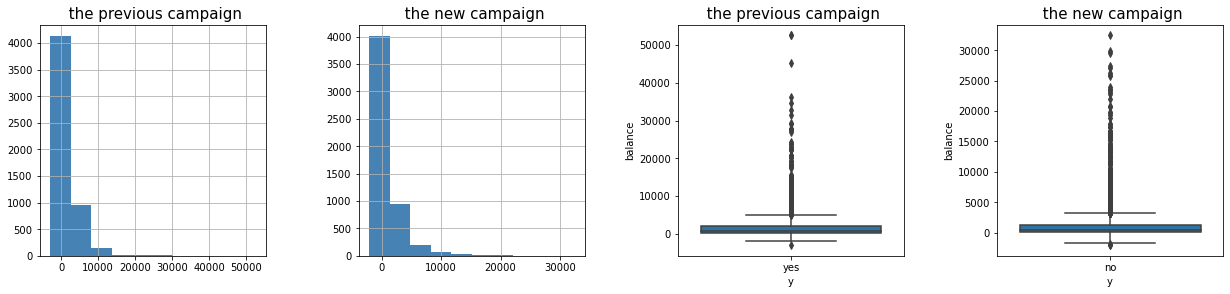

In [34]:
item=Plot(df_success,df_fail,'balance','balance',df_success.balance,df_fail.balance,1)
item.plot()

Now, two box plots are ok.

For the next step, we test whether both groups have equal variance or not. 

In [35]:
item=tests(df_success['balance'], df_fail['balance'])
item.levene_test()

levene p-value: 0.000
Reject null hypothesis:  the variance between groups is not equal 


From the histograms of both groups, roughly, the balance of customers is normally distributed.

The variance between groups is not equal, thus, we should use Welch's t-test.

We also try the Mann-Whitney test.

In [36]:
item=tests(df_success['balance'], df_fail['balance'])
item.welch_test()

Mann-Whitney p-value criterion: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


In [37]:
item.mann_Whitney_test()

Mann-Whitney p-value criterion: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


Both statistical tests show that the average yearly balance is an important variable, and should be considered in the future campaign.

We dig into this variable to draw some insight.

We split up the customers into four different groups

Negative: their balance is negative

Low: their balance is positive but less than 500 euros

Medium: Balance between 500 and 2000 euros

High: Balance higher than 2000 euros

Then, we try to answer the question of the level of customers' balance and subscribing to the bank term deposit related to each other?

Before this, we define the following class to generate the required dataframes.

In [67]:
class table_generator():
    
    """This class generates balance, housing, and education tables
          args: df_success: a dataframe represents the successful cases in the new campaign
                  df_fail: a dataframe represents the unsuccessful cases in the new campaign
         return: the required tables"""
    
    def __init__(self, df_success,df_fail):
        self.df_success= df_success
        self.df_fail=df_fail
    
    def balance(self):    
        df_s_negative=self.df_success[(self.df_success['balance'] < 0)]
        df_s_low=self.df_success[(self.df_success['balance'] > 0)& (self.df_success['balance']<=500)]
        df_s_medium=self.df_success[(self.df_success['balance'] > 500)& (self.df_success['balance']<2000)]
        df_s_high=self.df_success[(self.df_success['balance']>=2000)]

        df_f_negative=self.df_fail[(self.df_fail['balance'] < 0)]
        df_f_low=self.df_fail[(self.df_fail['balance'] > 0)& (self.df_fail['balance']<=500)]
        df_f_medium=self.df_fail[(self.df_fail['balance'] > 500)& (self.df_fail['balance']<2000)]
        df_f_high=self.df_fail[(self.df_fail['balance']>=2000)]
    
        d_balance=[[df_f_negative.shape[0], df_s_negative.shape[0]],
            [df_f_low.shape[0], df_s_low.shape[0]],
             [df_f_medium.shape[0], df_s_medium.shape[0]],
            [df_f_high.shape[0], df_s_high.shape[0]]]
    
        data_dict = {'accept bank offer': [df_s_negative.shape[0], df_s_low.shape[0],
                  df_s_medium.shape[0], df_s_high.shape[0]],
                  'reject bank offer': [df_f_negative.shape[0], df_f_low.shape[0],
                   df_f_medium.shape[0], df_f_high.shape[0]]}
        df_balance = pd.DataFrame(data_dict, index=['negative balance','low balance','medium balance','high balance'])
    
        return d_balance,df_balance
    
    def education(self):
        d_education=[[self.df_success[self.df_success['education']=="primary"].shape[0], self.df_fail[self.df_fail['education']=="primary"].shape[0]],
                   [self.df_success[self.df_success['education']=="secondary"].shape[0], self.df_fail[self.df_fail['education']=="secondary"].shape[0]],
               [df_success[df_success['education']=="tertiary"].shape[0],
                  df_fail[df_fail['education']=="tertiary"].shape[0]]]
        
        data_dict = {'accept bank offer': [df_success[df_success['education']=="primary"].shape[0], df_success[df_success['education']=="secondary"].shape[0],
                df_success[df_success['education']=="tertiary"].shape[0]],
        'reject bank offer': [df_fail[df_fail['education']=="primary"].shape[0], df_fail[df_fail['education']=="secondary"].shape[0],
               df_fail[df_fail['education']=="tertiary"].shape[0]]}
        df_education = pd.DataFrame(data_dict, index=['primary','secondary','tertiary'])
        
        return d_education,df_education 
    
    def housing_loan(self):
        d_loan=[[self.df_success[self.df_success['housing']=="yes"].shape[0], self.df_fail[self.df_fail['housing']=="yes"].shape[0]],
                      [self.df_success[self.df_success['housing']=="no"].shape[0], self.df_fail[self.df_fail['housing']=="no"].shape[0]]]
        data_dict = {'accept bank offer': [df_success[df_success['housing']=="yes"].shape[0],df_success[df_success['housing']=="no"].shape[0]],
               'reject bank offer': [df_fail[df_fail['housing']=="yes"].shape[0], df_fail[df_fail['housing']=="no"].shape[0]]}
        df_loan = pd.DataFrame(data_dict, index=['have loan','without loan'])
        return d_loan,df_loan

In [68]:
item=table_generator(df_success,df_fail)
d_balance,df_balance=item.balance()

Since the level of customers' balance is a categorical variable, we use the Chi-Square test to answer the question

In [40]:
item=tests(d_balance,None)
item.chi_Square_test()

Chi-Square test p-value: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


In [69]:
df_balance

,accept bank offer,reject bank offer
negative balance,210,488
low balance,1680,1967
medium balance,1698,1507
high balance,1409,914


From the test and above table, customers with higher levels of balance are willing to accept the bank offers more than customers with lower levels of balance

Consequently, we should focus more on customers with a higher level of balance for future campaigns.

The next variable is age.

Here, the question is whether age and subscribing to the bank term deposit are related to each other?

Again, since age is continuous and our sample size is large we will leverage the z-test or Welch's t-test, or the Mann-Whitney test to answer the question.

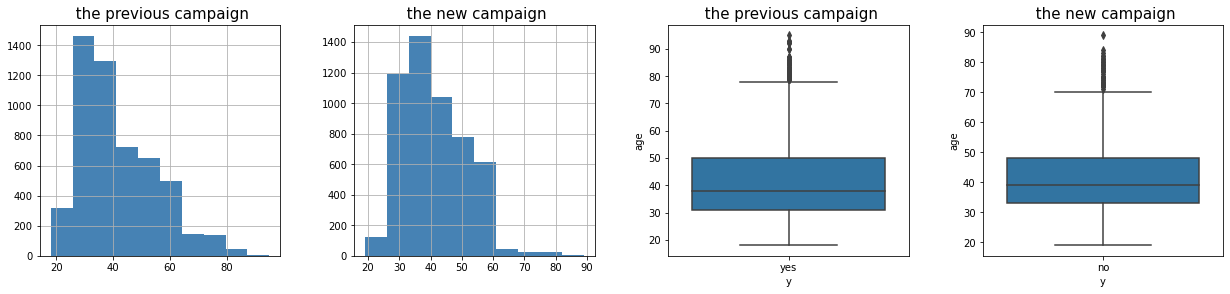

In [42]:
item=Plot(df_success,df_fail,'age','age',df_success.age,df_fail.age,1)
item.plot()

According to both histograms, age does not seem to be normally distributed in both groups. 

Thus, we try the Mann-Whitney test.

In [43]:
item=tests(df_success['age'], df_fail['age'])
item.mann_Whitney_test()

Mann-Whitney p-value criterion: 0.526
Fail to reject the null hypothesis: the difference between the groups is statistically insignificant


The Mann-Whitney test concludes that the difference between the groups is not statistically significant. 

**Consequently, probably, age is not an important variable.**

The next variable is the number of calls, which can be important.

If we talk with our customers multiple times, maybe he/she gets interested or vice versa. 

**Question: number of calls and subscribing to the bank term deposit are related to each other**

Again, since the number of calls is continuous and our sample size is large we will leverage the z-test or Welch's t-test to answer the question.

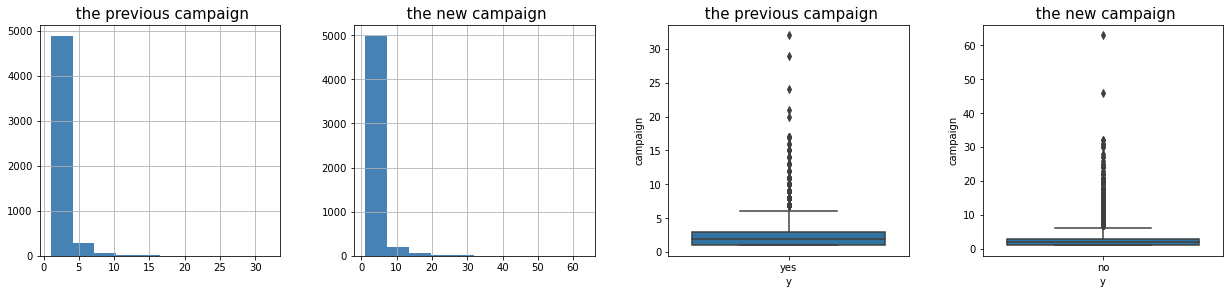

In [44]:
item=Plot(df_success,df_fail,'campaign','campaign',df_success.campaign,df_fail.campaign,1)
item.plot()

We remove the anomaly existed in the group of people who said no. 

In [45]:
df_fail = df_fail[df_fail.campaign < df_fail.campaign.max()]

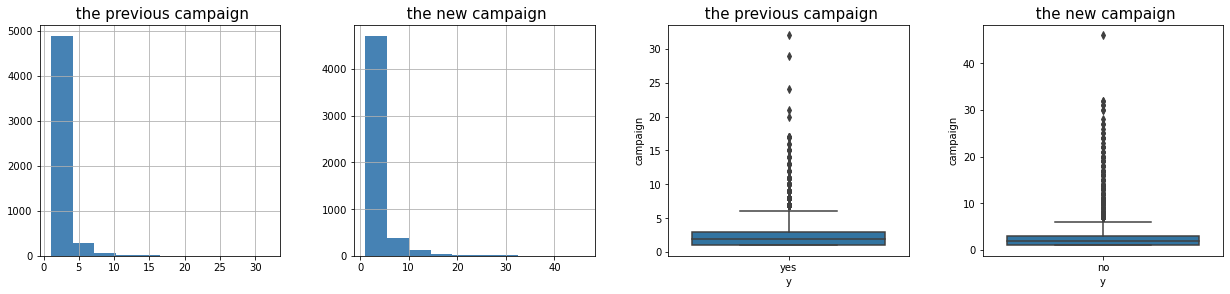

In [46]:
item=Plot(df_success,df_fail,'campaign','campaign',df_success.campaign,df_fail.campaign,1)
item.plot()

Box plots are ok, now, we apply our tests.

In [47]:
item=tests(df_success['campaign'], df_fail['campaign'])
item.levene_test()

levene p-value: 0.000
Reject null hypothesis:  the variance between groups is not equal 


In [48]:
item.welch_test()

Mann-Whitney p-value criterion: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


In [49]:
item.mann_Whitney_test()

Mann-Whitney p-value criterion: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


Both tests show that number of calls may affect willingness to subscribe to the bank term deposit.

Therefore, we should consider optimization of this term for future marketing.

The next question is **whether the level of education/ having a housing loan and subscribing to the bank term deposit are related to each other?**

Since all of the above terms are categorical, we use the Chi-Square test to answer the question.

In [50]:
item=table_generator(df_success,df_fail)
d_education,df_education=item.education()

In [51]:
item=tests(d_education, None)
item.chi_Square_test()

Chi-Square test p-value: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


In [52]:
df_education

,accept bank offer,reject bank offer
primary,591,847
secondary,2448,2765
tertiary,1996,1469


Our Chi-Square test shows that the level of education is an important variable.

**We can observe that people with higher education accepted the bank offers more than people with lower levels of education.** 

**Consequently, we should focus more on people with higher education in future marketing campaigns.**

Having a housing loan is the next variable.

In [53]:
item=table_generator(df_success,df_fail)
d_loan,df_loan=item.housing_loan()

In [54]:
item=tests(d_loan, None)
item.chi_Square_test()

Chi-Square test p-value: 0.000
Reject null hypothesis: the difference between the groups is statistically significant


In [55]:
df_loan

,accept bank offer,reject bank offer
have loan,1935,3061
without loan,3352,2226


Our Chi-Square test shows that having housing loan is an important variable.

We can observe that people without housing loan accepted the bank offers more than people with housing loan.

Consequently, we should focus more on people without housing loan in future marketing campaigns.

**Answer to question 3: It seems that having housing loan, the level of education, and the number of calls should be considered in future campaigns.**

### Question 4: Can we use the data for future customers' behavior prediction?

In this section, we assess that if our available data is suitable to predict future customers' behavior or not.

To this end, we need to apply some data processing.

First, we remove unrelated columns to the goal, i.e., previous, pdays, duration, month, day, contact, defualt, and poutcome.

columns previous, pdays, and poutcome related to the previous campaign.

Since, only 1% of the customers have credit default, this column is irrelevant. 

Since, the customers were contacted only via phone, this column is also irrelevant.

Finally, columns month, day, and duration are only related to the last call; thus, they have no information about the whole procedure. Hence, we remove them.

In [29]:
df = df.drop(columns=['contact', 'day','default','pdays','previous'],axis=1)

We have some unknown values in columns job and education.
let's see how many entries of them are unknown. 

In [30]:
print('percantage of unknown values in column job:{}'.format(df[df.job=='unknown'].shape[0]/df.shape[0]))

percantage of unknown values in column job:0.006370131162770122


In [31]:
print('percantage of unknown values in column education:{}'.format(df[df.education=='unknown'].shape[0]/df.shape[0]))

percantage of unknown values in column education:0.04107407489327818


Since the number of unknown values in columns job and education is not significant, we remove them. 

In [32]:
df.drop(df.index[df['poutcome']=='unknown'], inplace=True)
df.drop(df.index[df['poutcome']=='other'], inplace=True)
df.drop(df.index[df['job']=='unknown'], inplace=True)
df.drop(df.index[df['education']=='unknown'], inplace=True)

The column goal in this section is column y. Thus, we separate it from the dataframe.

Before, applying some classification algorithms, we need to use one-hot encoding for categorical columns, and normalize our numeric columns. 

In [33]:
# seperating column default from the dataset
y=df['y']
df=df.drop(columns='y')

In [34]:
# select categorical and numerical features+ one-hot encosing+ normalized the numerical columns
cat_ind = df.select_dtypes(include=['object']).columns
num_ind = df.select_dtypes(include=['int64']).columns
ct = ColumnTransformer([('o',OneHotEncoder(drop='first'),cat_ind),('n',Normalizer(),num_ind)])

In [35]:
# the matrix contains features
X = (ct.fit_transform(df))
X=X.toarray()

In [36]:
# making the binary targets 
y=y.to_numpy()
y=np.where(y == 'no', 0, 1)

In [37]:
print('percentage of success: {}'.format((np.count_nonzero(y == 1)/y.shape[0])*100))

percentage of success: 24.523071906081853


As, we can see, our problem is an imbalanced classification problem. 

Next, we try some supervised machine learning classification methods. 

First of all, since we use logistic regression, we should check co-linearity between predictors via VIF score. 

Then, based on the VIF scores, columns whose VIF scores are higher than 2.6 will be removed.  

In [73]:
def vif_truncator(X,s_tresh):
    # Calculating VIF
    X_dataframe=pd.DataFrame(X)
    vif = pd.DataFrame()
    vif["variables"] = X_dataframe.columns
    vif["VIF"] = [variance_inflation_factor(X_dataframe.values, i) for i in range(X_dataframe.shape[1])]
    # removing rows where their vif values are larger than a threshold from X
    v_list=list(vif[vif.VIF > s_tresh].variables)
    X=np.delete(X, [i for i in v_list], 1)
    return(X)


To respond to the fourth question, we implement Bagging and Random Forest decision trees, logistic regression, XGBoost Random Forest, and k-nearest neighbors classifier. 

To evaluate our models, k-fold cross-validation is used, and our metric evaluation is f1 score.

In [74]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    # evaluate model 
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    return scores

In [75]:
def get_models():
    models, names = list(), list()
    # BG
    models.append(BaggingClassifier(n_estimators = 100,random_state = 42, n_jobs = -1))
    names.append('BG')
    # LR
    models.append(LogisticRegression(solver='sag'))
    names.append('LR')
    # RF
    models.append(RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1))
    names.append('RF')
    # XG boost
    models.append(XGBRFClassifier(n_estimators = 100,scale_pos_weight=10))
    names.append('XGBoost')
    # NB
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # Baseline
    models.append(DummyClassifier(strategy='constant', constant=1))
    names.append('base')
    return models, names

In [76]:
# define models
models, names = get_models()
results = list()

>BG 0.629 (0.010)
>LR 0.590 (0.015)
>RF 0.634 (0.007)
>XGBoost 0.606 (0.014)
>KNN 0.515 (0.020)
>base 0.394 (0.000)


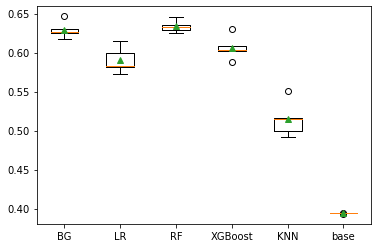

In [77]:
# evaluate each model
for i in range(len(models)):
    if names[i]=='LR':
        X_truncate=vif_truncator(X,2.6)
        scores=evaluate_model(X_truncate,y,models[i])
        results.append(scores)
        print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    else:
        scores=evaluate_model(X,y,models[i])
        results.append(scores)
        print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

From the figure, XGBoost Random Forest, random forest and bagging decision trees show some skills compared with 
the baseline classifier (classifying all customers as successful cases, i.e., in this case, all rows of column y are one ). 

To improve the performance of our bagging decision trees, since our problem is an imbalanced classification problem, we leverage oversampling (increasing the number of samples of minority class) and undersampling methods (decreasing increasing the number of samples of majority class).

First, we calculate feature importance in the XGboost model to see whether removing some features is necessary or not.

Feature: 0, Score: 0.00715
Feature: 1, Score: 0.00443
Feature: 2, Score: 0.00195
Feature: 3, Score: 0.00571
Feature: 4, Score: 0.00894
Feature: 5, Score: 0.00003
Feature: 6, Score: 0.00383
Feature: 7, Score: 0.00848
Feature: 8, Score: 0.00465
Feature: 9, Score: 0.01231
Feature: 10, Score: 0.00252
Feature: 11, Score: 0.00651
Feature: 12, Score: 0.00617
Feature: 13, Score: 0.00264
Feature: 14, Score: 0.00740
Feature: 15, Score: 0.00188
Feature: 16, Score: 0.13161
Feature: 17, Score: 0.03565
Feature: 18, Score: 0.00541
Feature: 19, Score: 0.00381
Feature: 20, Score: 0.01112
Feature: 21, Score: 0.00295
Feature: 22, Score: 0.04720
Feature: 23, Score: 0.00120
Feature: 24, Score: 0.04032
Feature: 25, Score: 0.05359
Feature: 26, Score: 0.01292
Feature: 27, Score: 0.02696
Feature: 28, Score: 0.02004
Feature: 29, Score: 0.00832
Feature: 30, Score: 0.07168
Feature: 31, Score: 0.03894
Feature: 32, Score: 0.10495
Feature: 33, Score: 0.06587
Feature: 34, Score: 0.07893
Feature: 35, Score: 0.15395


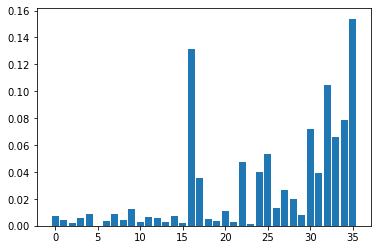

In [9]:
model =XGBRFClassifier(n_estimators = 100,scale_pos_weight=10)
sm = SMOTE(sampling_strategy=0.5,random_state=42)
rs=RandomUnderSampler(sampling_strategy=0.4)
X_res, y_res = sm.fit_resample(X, y)
# fit the model
model.fit(X_res, y_res)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [11]:
v_list=[]
for i,v in enumerate(importance):
    if v<0.025:
        v_list.append(i)
X=np.delete(X, v_list, 1)

In [56]:
# define pipeline
model=RandomForestClassifier(n_estimators = 100,random_state = 42, n_jobs = -1)
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [57]:
score=evaluate_model(X,y,pipeline)
print('Mean f1 score: %.3f' % mean(score))

Mean f1 score: 0.670


The result shows that we could improve the performance of our classifier.

**Answer to question 4: Yes, we may use the trained predictor (based on the current dataset) to predict the answer of customers in future campaigns**